In [ ]:
## Notebook env: mirtud_env (R kernel)

In [1]:
library(readr)
library(readxl)
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(tximport)
library(mygene)
library(DESeq2)
library(GenomicFeatures)
library(ensembldb)
library(AnnotationHub)
library(EnrichmentBrowser)

path = '/home/ssobti/projects/mir_tud/wetlab_followup_data/bulk_rna_seq/annotated_expression/'
path_to_output = '/home/ssobti/projects/mir_tud/output_data/wetlab_followup/bulk_rna_seq/pathway_validation/'

#BiocManager::install('clusterProfiler', lib = '/home/ssobti/projects/mir_tud/packages/gsea_R_pkgs')
#install.packages('genekitr', lib = '/home/ssobti/projects/mir_tud/packages/gsea_R_pkgs')
.libPaths('/home/ssobti/projects/mir_tud/packages/gsea_R_pkgs')
#library(genekitr)
library(clusterProfiler)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame,

### Deseq ###

In [2]:
## make gene annotations
txdb <- makeTxDbFromGFF(file = '/home/ssobti/genomes/hg38/gencode.v33.annotation.gtf.gz', dataSource = 'Gencode', organism = 'Homo sapiens')
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")

Import genomic features from the file as a GRanges object ... 


OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK

'select()' returned 1:1 mapping between keys and columns



In [3]:
## load in data ## 
files = list.files(path = '/home/ssobti/projects/mir_tud/wetlab_followup_data/bulk_rna_seq/raw/salmon_out/', pattern='quant.sf',full.names = TRUE, recursive = TRUE)
files = gsub(pattern = '//', replacement = '/', files)
file_sample_names = lapply(stringr::str_split(string = gsub(lapply(stringr::str_split(string = files, pattern = '/'), '[[', 10), pattern = '_salmon', replacement = ''), pattern = '_'), '[[', 1)
names(files) = file_sample_names

## since txOut is TRUE, transcript level informations (ie some genes have multiple unique transcripts and data is summarized at the transcript level)
txi = tximport(files, type = "salmon", tx2gene = tx2gene, txOut = TRUE)
txi.gene <- summarizeToGene(txi, tx2gene) ## this function summarizes the reads to gene level instead of transcript (so diff transcripts of same gene are consolidated) -- use this for analysis!!
sample_meta = read.csv('/home/ssobti/projects/mir_tud/wetlab_followup_data/bulk_rna_seq/TuD_bulkRNAseq_samplesheet.csv')
sample_meta = sample_meta %>% arrange(factor(Label, levels = colnames(txi.gene$counts)))
sample_meta$samplefactor = factor(sapply(stringr::str_split(sample_meta$Sample, '_'), '[[', 1))
colnames(txi.gene$counts) = colnames(txi.gene$abundance) = colnames(txi$abundance) = colnames(txi$counts) = sample_meta %>% pull(Sample) %>% as.character()

reading in files with read_tsv



1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 


summarizing abundance

summarizing counts

summarizing length



In [4]:
## adding gene symbols to exp data ##
## obtain gene symbol database v99 ensembl to match v33 gencode
ah = AnnotationHub()
ensembl99 = query(ah, "EnsDb.Hsapiens.v99")
ensembl99 = ah[['AH78783']]

## add gene symbols
exp_data_counts = txi.gene$counts
gene_ids = sapply(str_split(rownames(exp_data_counts), pattern = '\\.'), '[[', 1)
geneIDs <- ensembldb::select(ensembl99, keys = gene_ids, keytype = "GENEID", columns = c("GENEID", "SYMBOL"))
exp_data_counts = cbind(geneIDs, exp_data_counts)

exp_data_tpm = txi.gene$abundance
gene_ids = sapply(str_split(rownames(exp_data_tpm), pattern = '\\.'), '[[', 1)
geneIDs <- ensembldb::select(ensembl99, keys = gene_ids, keytype = "GENEID", columns = c("GENEID", "SYMBOL"))
exp_data_tpm = cbind(geneIDs, exp_data_tpm)

## save the gene count data ##
## save the abunance and count data ##

write.csv(exp_data_tpm, paste0(path,"gene_abundance_tpm_salmon.csv"), quote=FALSE)
write.csv(exp_data_counts, paste0(path,"gene_read_count_salmon.csv"), quote=FALSE)

loading from cache



In [3]:
## run DESeq2 ##
#dds <- DESeqDataSetFromTximport(txi.gene, colData = sample_meta, design = ~ samplefactor)
#dds <- DESeq(dds)
#saveRDS(dds, file = paste0(path_to_output, 'dds_salmon.rds'))
#saveRDS(sample_meta, file = paste0(path_to_output, 'sample_meta.rds'))

ah = AnnotationHub()
ensembl99 = query(ah, "EnsDb.Hsapiens.v99")
ensembl99 = ah[['AH78783']]

dds = readRDS(file = paste0(path_to_output, 'dds_salmon.rds'))
sample_meta = readRDS(file = paste0(path_to_output, 'sample_meta.rds'))

pathway_samples = c('hsa.miR.34a.5p', 'hsa.miR.34c.5p', 'hsa.miR.449a', 'hsa.miR.629.3p', 'hsa-miR-139-5p', 'tRNA.Val.CAC.2.1.rh', 'tRNA.Leu.CAA..2.1.1.1t', 'tRNA.Leu.CAG..7.1.1.1t', 'tRNA.Val.CAC.2.1.3t', 'tRNA.Leu.CAG..7.1.1.rh', 'tRNA.Leu.CAG..7.1.1.3t', 'tRNA.Ile.TAT.1.1.lh', 'tRNA.Ile.TAT.1.1.1t')
control_samples = rep('NC1', length(pathway_samples))

## extract results for pathway hits ##
res = list()
for (i in 1:length(pathway_samples)){
  res[[i]] = results(dds, contrast = c('samplefactor', pathway_samples[i], 'NC1')) %>% as.data.frame()
  gene_ids = sapply(str_split(rownames(res[[i]]), pattern = '\\.'), '[[', 1)
  gene_df = ensembldb::select(ensembl99, keys = gene_ids, keytype = "GENEID", columns = c("GENEID", "SYMBOL"))
  res[[i]]$symbol = gene_df$SYMBOL
}
names(res) = sample_meta %>% dplyr::filter(Class %in% 'Rotational PCR') %>% pull(samplefactor) %>% as.character() %>% unique()
saveRDS(res, file = paste0(path_to_output, 'pathway_hits_salmon.rds'))
## extract results for pca of samples ##
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
z <- plotPCA(vsd, intgroup=c("samplefactor"), returnData = TRUE)

loading from cache



Warning message:
"ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


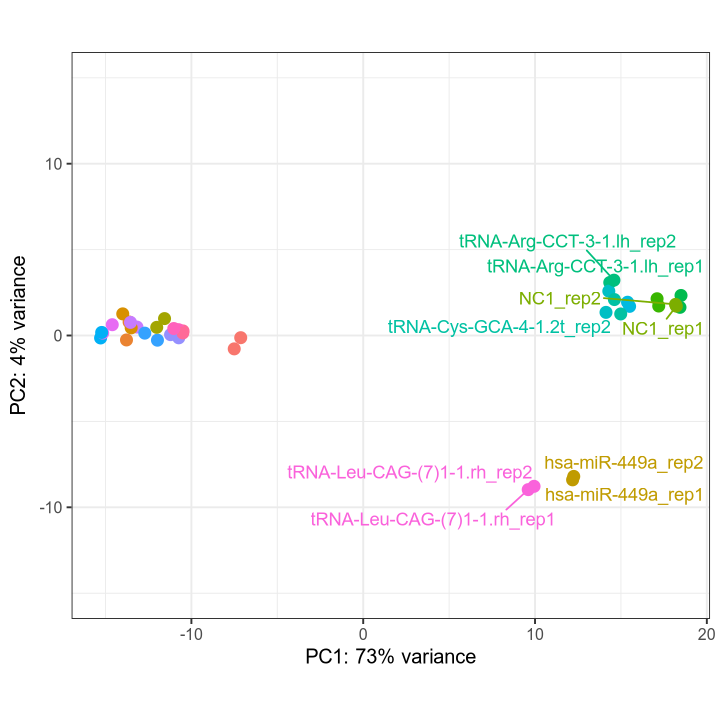

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)
percentVar <- round(100 * attr(z, "percentVar"))
ggplot(z, aes(PC1, PC2, color = samplefactor, label = name)) +
  geom_point(size=3, show.legend = F) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_text_repel(position = 'nudge', show.legend = F, max.overlaps = 20) +
  coord_fixed() + theme_bw(12) + ylim(-15,15) 


### Heatmap ###

In [2]:
## load up to this point ##
sample_meta = readRDS(file = paste0(path_to_output, 'sample_meta.rds'))
res = readRDS(file = paste0(path_to_output, 'pathway_hits_salmon.rds'))
exp_data_counts = read.csv(paste0(path,"gene_read_count_salmon.csv"), row.names = 1)

In [7]:
## look at genes in associated pathways from orginal screen (including those we see directly see shift in expression) ##
## draw heatmaps of genes from each pathway? or do pathway scores to make it faster?
## These pathways are from GO_Biological_Process_2021 gene sets

## ** = key pathways to investigate first

## 'hsa.miR.34a.5p' / 'hsa.miR.34c.5p' / 'hsa.miR.449a' (miR−34−5p/449−5p cluster): GO:0098708 **, GO:0046351 **, GO:0140271 **
## 'hsa.miR.629.3p': GO:0003056, GO:0045986, GO:0010839
## 'hsa-miR-139-5p': GO:0006695 **, GO:1902653 **, GO:0016126 **
## 'tRNA.Val.CAC.2.1.rh': GO:0031440 **, GO:0098962, GO:1900363 **
## 'tRNA.Leu.CAA..2.1.1.1t' / 'tRNA.Leu.CAG..7.1.1.1t' (tRF_Leu_CAA.CAG_2 supercluster): GO:0032069, GO:0032020 **, GO:0060700
## 'tRNA.Val.CAC.2.1.3t': GO:0032069, GO:0032020 **, GO:0060700
## 'tRNA.Leu.CAG..7.1.1.rh' / 'tRNA.Leu.CAG..7.1.1.3t' (tRF_Leu_CAG_2 supercluster): GO:0031204, GO:1903895 **, GO:0030705
## 'tRNA.Ile.TAT.1.1.lh' / 'tRNA.Ile.TAT.1.1.1t' (tRF_Ile_TAT_2 supercluster): GO:0010757, GO:0002544 **, GO:0010754 **

In [3]:
## keep genes in res with p-adj <= 0.05 ##
#res = lapply(res, function(x) x %>% dplyr::filter(padj <= 0.05))

## get GO sets
go_genesets = getGenesets('hsa', db = 'enrichr', gene.id.type = 'SYMBOL', lib = 'GO_Biological_Process_2021')

hits_pathway_annotations = list('miR-34-5p/449-5p' = c('GO:0098708', 'GO:0046351', 'GO:0140271'), 
            'hsa.miR.629.3p' = c('GO:0003056', 'GO:0045986', 'GO:0010839'),
            'hsa-miR-139-5p' = c('GO:0006695', 'GO:1902653', 'GO:0016126'),
            'tRNA.Val.CAC.2.1.rh' = c('GO:0031440', 'GO:0098962', 'GO:1900363'),
            'tRF_Leu_CAA.CAG_2' = c('GO:0032069', 'GO:0032020', 'GO:0060700'),
            'tRNA.Val.CAC.2.1.3t' = c('GO:0032069', 'GO:0032020', 'GO:0060700'),
            'tRF_Leu_CAG_2' = c('GO:0031204', 'GO:1903895', 'GO:0030705'),
            'tRF_Ile_TAT_2' = c('GO:0010757', 'GO:0002544', 'GO:0010754'))

hits_pathway_annotations = as.character(unlist(hits_pathway_annotations))

hits_pathway_gene_sets = lapply(hits_pathway_annotations, function(x) go_genesets[[grep(x, names(go_genesets))]])
prefix = hits_pathway_annotations
suffix = stringr::str_sub(str_remove(as.character(sapply(hits_pathway_annotations, function(x) names(go_genesets)[grep(x, names(go_genesets))])), pattern = "^.*?(_|-)"), end = -14)
names(hits_pathway_gene_sets) = paste(prefix, toupper(suffix), sep = ' ')


Attaching package: 'RCurl'


The following object is masked from 'package:tidyr':

    complete




'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



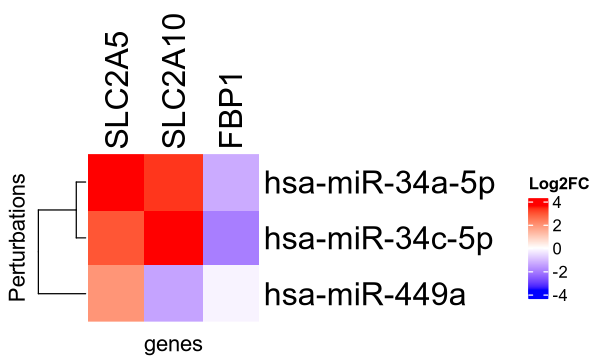

In [99]:
## 'hsa.miR.34a.5p' / 'hsa.miR.34c.5p' / 'hsa.miR.449a' (miR−34−5p/449−5p cluster) ##

filtered_res = lapply(res[1:3], function(x) x %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[1:3])) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)[1:3]
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('SLC2A5', 'SLC2A10', 'FBP1'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 5
hfix = 3

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = 0
lower_bound = avg - 1.5*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = avg + 1.5*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

## SLC2A5 (fructose transporter) SLC2A10 (glucose transporter) upregulated indicating higher influx of fructose and glucose
## FBP1 downregulation causes upregulation of glycolycis and import of glucose into cells (https://www.sciencedirect.com/science/article/pii/S1535610813000421)
#ggsave('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/G1.pdf', width = wfix, height = hfix)


Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


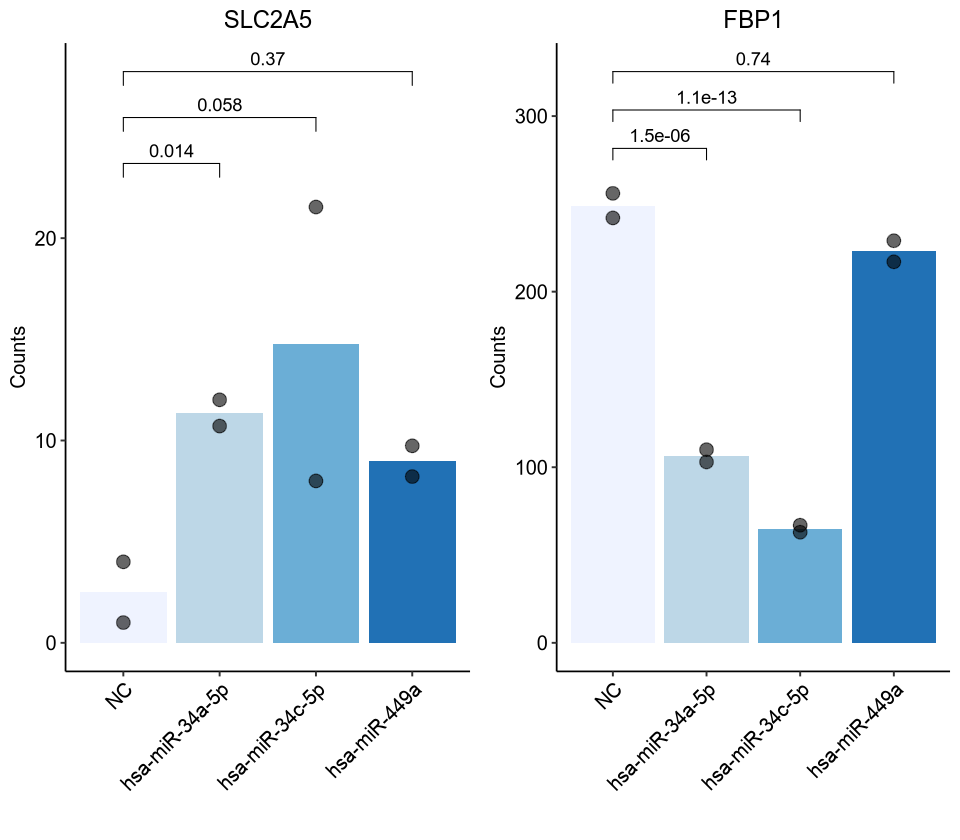

In [5]:
options(repr.plot.width = 8, repr.plot.height = 7)
genes = c('SLC2A5', 'FBP1')
pvals_df = bind_rows(lapply(res[1:3], function(x) x %>% dplyr::filter(symbol %in% genes) %>% dplyr::select(symbol, log2FoldChange, padj)), .id = 'miR')
select_genes_counts = exp_data_counts %>% dplyr::filter(SYMBOL %in% genes) %>% dplyr::select(SYMBOL, 'hsa.miR.34a.5p_rep1', 'hsa.miR.34a.5p_rep2', 'hsa.miR.34c.5p_rep1', 'hsa.miR.34c.5p_rep2', 'hsa.miR.449a_rep1', 'hsa.miR.449a_rep2', NC1_rep1, NC1_rep2) %>% pivot_longer(cols = c('hsa.miR.34a.5p_rep1', 'hsa.miR.34a.5p_rep2', 'hsa.miR.34c.5p_rep1', 'hsa.miR.34c.5p_rep2', 'hsa.miR.449a_rep1', 'hsa.miR.449a_rep2', 'NC1_rep1', 'NC1_rep2'), names_to = 'Sample', values_to = 'Counts') %>% separate_wider_delim(Sample, "_", names = c('Sample', 'rep'), too_many = "merge") %>% mutate(rep = str_sub(rep, -1)) %>% mutate(Sample = plyr::mapvalues(Sample, from = c('hsa.miR.34a.5p', 'hsa.miR.34c.5p', 'hsa.miR.449a'), to = c('hsa-miR-34a-5p', 'hsa-miR-34c-5p', 'hsa-miR-449a')))
# fig_path = '/home/ssobti/projects/mir_tud/'
# saveRDS(pvals_df, paste0(fig_path, 'fig_output/data/fig4/miR_34_pvals_df.rds'))
# saveRDS(select_genes_counts, paste0(fig_path, 'fig_output/data/fig4/miR_34_selected_genes_counts.rds'))
select_genes_counts$Sample[select_genes_counts$Sample == 'NC1'] = 'NC'
select_genes_counts$Sample = factor(select_genes_counts$Sample, levels = c('NC', 'hsa-miR-34a-5p', 'hsa-miR-34c-5p', 'hsa-miR-449a'))
p.ad_SLC2A5 = pvals_df %>% dplyr::filter(symbol == 'SLC2A5') %>% arrange(factor(symbol, levels = genes)) %>% pull(padj) %>% signif(2)
p.ad_FBP1 = pvals_df %>% dplyr::filter(symbol == 'FBP1') %>% arrange(factor(symbol, levels = genes)) %>% pull(padj) %>% signif(2)

y.pos_SLC2A5 = select_genes_counts %>% dplyr::filter(SYMBOL == 'SLC2A5') %>% summarize(max = max(Counts)) %>% pull(max) * 1.1
stat.test_SLC2A5 = data.frame(.y. = 'len', group1 = rep('NC', length(unique(pvals_df$miR))), group2 = c('hsa-miR-34a-5p', 'hsa-miR-34c-5p', 'hsa-miR-449a'), p.adj = p.ad_SLC2A5, y.position = y.pos_SLC2A5)

y.pos_FBP1 = select_genes_counts %>% dplyr::filter(SYMBOL == 'FBP1') %>% summarize(max = max(Counts)) %>% pull(max) * 1.1
stat.test_FBP1 = data.frame(.y. = 'len', group1 = rep('NC', length(unique(pvals_df$miR))), group2 = c('hsa-miR-34a-5p', 'hsa-miR-34c-5p', 'hsa-miR-449a'), p.adj = p.ad_FBP1, y.position = y.pos_FBP1)

SLC2A5_barplot = select_genes_counts %>% dplyr::filter(SYMBOL == 'SLC2A5') %>% ggplot(aes(Sample, Counts)) + geom_bar(aes(fill = Sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_pvalue_manual(stat.test_SLC2A5, label = 'p.adj', step.increase = 0.1) + ggtitle(genes[1]) +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('Counts') + scale_fill_brewer(palette = 'Blues', direction = 1) + scale_color_brewer(palette = 'Blues', direction = 1)

FBP1_barplot = select_genes_counts %>% dplyr::filter(SYMBOL == 'FBP1') %>% ggplot(aes(Sample, Counts)) + geom_bar(aes(fill = Sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_pvalue_manual(stat.test_FBP1, label = 'p.adj', step.increase = 0.1) + ggtitle(genes[2]) +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('Counts') + scale_fill_brewer(palette = 'Blues', direction = 1) + scale_color_brewer(palette = 'Blues', direction = 1)

ggarrange(SLC2A5_barplot, FBP1_barplot, ncol = 2, nrow = 1)

In [14]:
names(hits_pathway_gene_sets)[4:6]

[1] "GO:0003056 REGULATION_OF_VASCULAR_ASSOCIATED_SMOOTH_MUSCLE_CONTRACTION"
[2] "GO:0045986 NEGATIVE_REGULATION_OF_SMOOTH_MUSCLE_CONTRACTION"           
[3] "GO:0010839 NEGATIVE_REGULATION_OF_KERATINOCYTE_PROLIFERATION"

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



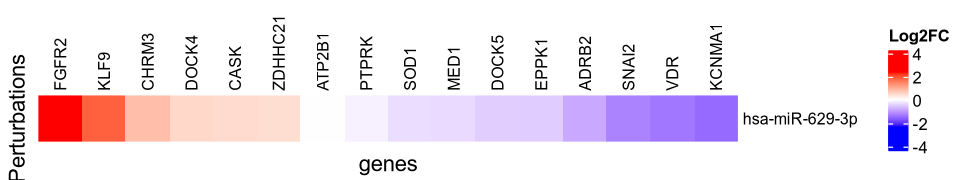

In [20]:
## 'hsa.miR.629.3p' ##

filtered_res = res[[4]] %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[4:6])) %>% dplyr::select(symbol, log2FoldChange)
rownames(filtered_res) = NULL
filtered_res = filtered_res %>% column_to_rownames(var = 'symbol')
colnames(filtered_res) = names(res)[4]
heatmap_data = filtered_res
#heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('GFI1B', 'CDKN1C', 'FOXO4'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 8
hfix = 1.5

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = mean(heatmap_data)
lower_bound = mean(heatmap_data) - 2*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = mean(heatmap_data) + 2*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')


#ggsave('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/G1.pdf', width = wfix, height = hfix)


In [4]:
names(hits_pathway_gene_sets)[7:9]

[1] "GO:0006695 CHOLESTEROL_BIOSYNTHETIC_PROCESS"      
[2] "GO:1902653 SECONDARY_ALCOHOL_BIOSYNTHETIC_PROCESS"
[3] "GO:0016126 STEROL_BIOSYNTHETIC_PROCESS"

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



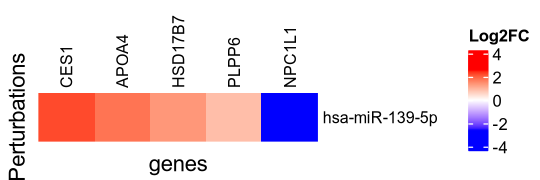

In [79]:
## 'hsa-miR-139-5p' ##

filtered_res = res[[5]] %>% dplyr::filter(symbol %in% c('HMGCR', 'NR5A2', 'VPS54', unlist(hits_pathway_gene_sets[7:9]))) %>% dplyr::select(symbol, log2FoldChange)
rownames(filtered_res) = NULL
filtered_res = filtered_res %>% column_to_rownames(var = 'symbol')
colnames(filtered_res) = names(res)[5]
heatmap_data = filtered_res
heatmap_data = heatmap_data %>% dplyr::filter(rownames(heatmap_data) %in% c('CES1', 'APOA4', 'HSD17B7', 'PLPP6', 'NPC1L1'))
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 4.5
hfix = 1.5

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = 0
lower_bound = avg - 1*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = avg + 1*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

## CES1 over-expression in macrophages leads to an increase in cholesteryl esterification and free cholesterol efflux, can indicate excess cholesterol in cells (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5736751/#:~:text=Human%20carboxylesterase%201%20(CES1)%20is,Ldlr%20%E2%88%92%2F%E2%88%92%20mice4.)
## APOA4 is upregulated which promotes cholesterol efflux and esterification leading to HDL formation to deposit cholesterol to liver, can indicate excess free cholesterol in cells, ie cholestorl and sterol synthesis may be in overdrive (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10243815/)
## HSD17B7 participates in postsqualene cholesterol biosynthesis (https://pubmed.ncbi.nlm.nih.gov/12829805/)
## PLPP6 (PDP1) regulates the biosynthesis of cholesterol and related sterols by dephosphorylating presqualene and farnesyl diphosphate, two key intermediates in this biosynthetic pathway (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2859554/)
## NPC1L1 imports cholesterol into cells and is downregulated here, indicating excess cholesterol within cells causing stoppage of cholesterol import (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3965667/)
## since HMGCR, NR5A2, VPS54 control cholesterol synthesis, homeostasis, and transport genes are normal targets of this miRNA, inhibiting this miRNA is leading to excess cholesterol/sterol synthesis in cells

## show bargraph of HSD17B7 and PLPP6 only with DESeq2 p-adj values (FDR/Benjamin Hockberg corrected) ##

#ggsave('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/G1.pdf', width = wfix, height = hfix)


Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


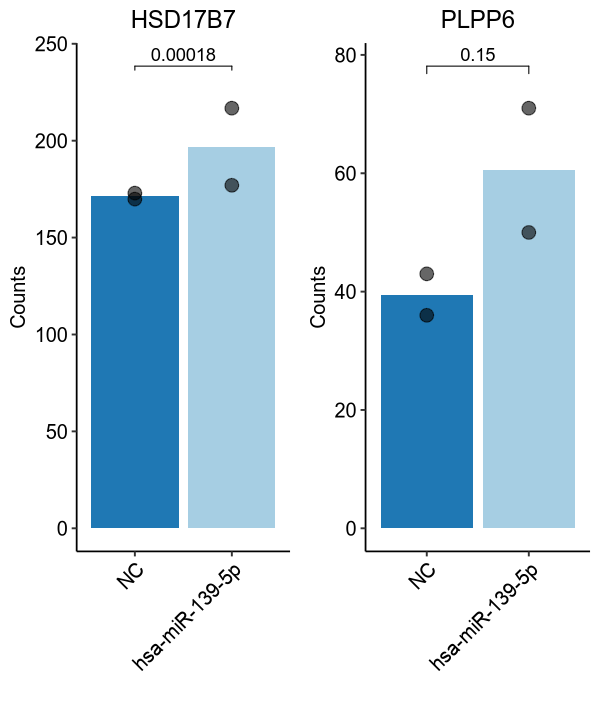

In [23]:
options(repr.plot.width = 5, repr.plot.height = 6)
genes = c('HSD17B7', 'PLPP6')
pvals_df = res[[5]] %>% dplyr::filter(symbol %in% genes) %>% dplyr::select(symbol, log2FoldChange, padj)
select_genes_counts = exp_data_counts %>% dplyr::filter(SYMBOL %in% genes) %>% dplyr::select(SYMBOL, 'hsa.miR.139.5p_rep1', 'hsa.miR.139.5p_rep2', NC1_rep1, NC1_rep2) %>% pivot_longer(cols = c('hsa.miR.139.5p_rep1', 'hsa.miR.139.5p_rep2', 'NC1_rep1', 'NC1_rep2'), names_to = 'Sample', values_to = 'Counts') %>% separate_wider_delim(Sample, "_", names = c('Sample', 'rep'), too_many = "merge") %>% mutate(rep = str_sub(rep, -1)) %>% mutate(Sample = plyr::mapvalues(Sample, from = 'hsa.miR.139.5p', to = 'hsa-miR-139-5p'))
# fig_path = '/home/ssobti/projects/mir_tud/'
# saveRDS(pvals_df, paste0(fig_path, 'fig_output/data/fig4/miR_139_pvals_df.rds'))
# saveRDS(select_genes_counts, paste0(fig_path, 'fig_output/data/fig4/miR_139_selected_genes_counts.rds'))
select_genes_counts$Sample[select_genes_counts$Sample == 'NC1'] = 'NC'
select_genes_counts$Sample = factor(select_genes_counts$Sample, levels = c('NC', 'hsa-miR-139-5p'))
p.ad = pvals_df %>% arrange(factor(symbol, levels = genes)) %>% pull(padj) %>% signif(2)
y.pos = select_genes_counts %>% group_by(SYMBOL) %>% summarize(max = max(Counts)) %>% arrange(factor(SYMBOL, levels = genes)) %>% pull(max) * 1.1
stat.test = data.frame(.y. = 'len', group1 = rep('NC', length(genes)), group2 = rep('hsa-miR-139-5p', length(genes)), p.adj = p.ad, y.position = y.pos)

barplots = list()
for (i in 1:length(genes)){
barplots[[i]] = select_genes_counts %>% dplyr::filter(SYMBOL %in% genes[i]) %>% ggplot(aes(Sample, Counts)) + geom_bar(aes(fill = Sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_pvalue_manual(stat.test[i,], label = 'p.adj') + ggtitle(genes[i]) +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('Counts') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)
}

ggarrange(plotlist = barplots, ncol = 2, nrow = 1)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



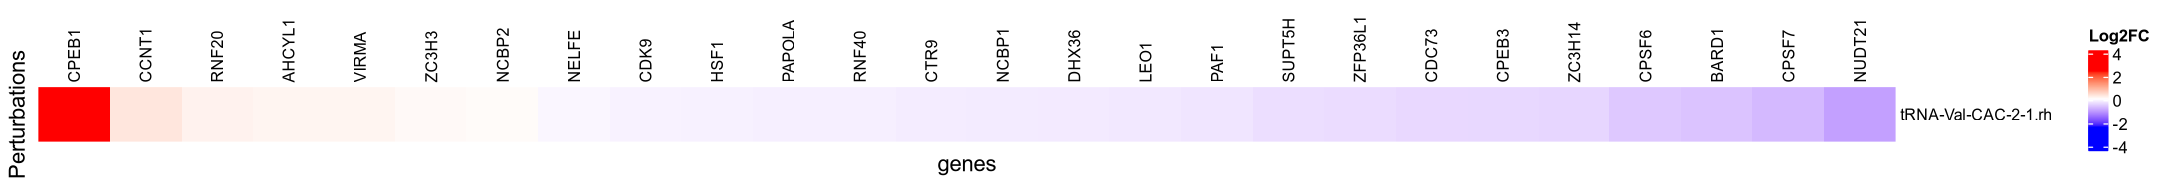

In [88]:
## 'tRNA-Val-CAC-2-1.rh' ##

filtered_res = res[[6]] %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[c(10,12)])) %>% dplyr::select(symbol, log2FoldChange)
rownames(filtered_res) = NULL
filtered_res = filtered_res %>% column_to_rownames(var = 'symbol')
colnames(filtered_res) = names(res)[6]
heatmap_data = filtered_res
#heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('GFI1B', 'CDKN1C', 'FOXO4'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 18
hfix = 1.5

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = mean(heatmap_data)
lower_bound = mean(heatmap_data) - 2*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = mean(heatmap_data) + 2*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')


#ggsave('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/G1.pdf', width = wfix, height = hfix)

## CPEB1 can cause alters polyadenylation length (usually increases it) of some mRNAs (https://pubmed.ncbi.nlm.nih.gov/20364142/) ##
## NUDT21 downregulation can lead to 3'UTR shortening by usage of alternative polyadenylation sites to add polyA tails (https://www.nature.com/articles/s41388-019-0714-9)

## show bargraph of NUDT21 and CPEB1 only with DESeq2 p-adj values (FDR/Benjamin Hockberg corrected) ##

Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


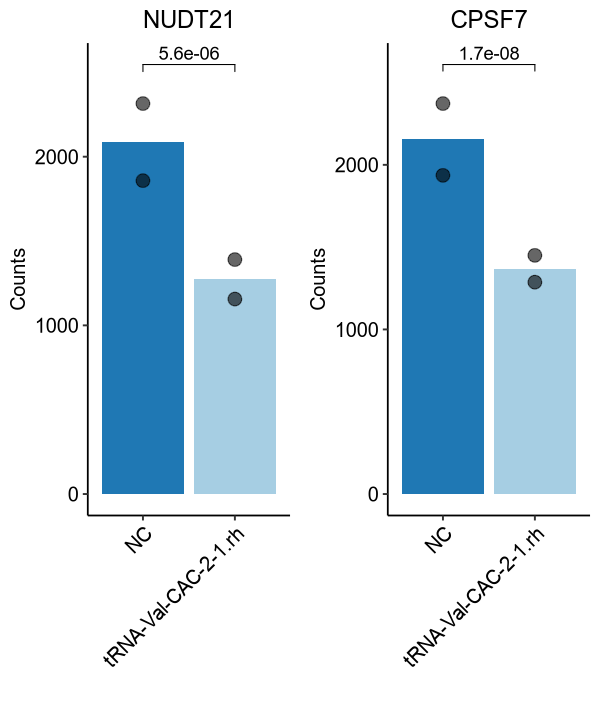

In [26]:
options(repr.plot.width = 5, repr.plot.height = 6)
genes = c('NUDT21', 'CPSF7')
pvals_df = res[[6]] %>% dplyr::filter(symbol %in% genes) %>% dplyr::select(symbol, log2FoldChange, padj)
select_genes_counts = exp_data_counts %>% dplyr::filter(SYMBOL %in% genes) %>% dplyr::select(SYMBOL, 'tRNA.Val.CAC.2.1.rh_rep1', 'tRNA.Val.CAC.2.1.rh_rep2', NC1_rep1, NC1_rep2) %>% pivot_longer(cols = c('tRNA.Val.CAC.2.1.rh_rep1', 'tRNA.Val.CAC.2.1.rh_rep2', 'NC1_rep1', 'NC1_rep2'), names_to = 'Sample', values_to = 'Counts') %>% separate_wider_delim(Sample, "_", names = c('Sample', 'rep'), too_many = "merge") %>% mutate(rep = str_sub(rep, -1)) %>% mutate(Sample = plyr::mapvalues(Sample, from = 'tRNA.Val.CAC.2.1.rh', to = 'tRNA-Val-CAC-2-1.rh'))
# fig_path = '/home/ssobti/projects/mir_tud/'
# saveRDS(pvals_df, paste0(fig_path, 'fig_output/data/fig4/tRF_Val_CAC_pvals_df.rds'))
# saveRDS(select_genes_counts, paste0(fig_path, 'fig_output/data/fig4/tRF_Val_CAC_selected_genes_counts.rds'))
select_genes_counts$Sample[select_genes_counts$Sample == 'NC1'] = 'NC'
select_genes_counts$Sample = factor(select_genes_counts$Sample, levels = c('NC', 'tRNA-Val-CAC-2-1.rh'))
p.ad = pvals_df %>% arrange(factor(symbol, levels = genes)) %>% pull(padj) %>% signif(2)
y.pos = select_genes_counts %>% group_by(SYMBOL) %>% summarize(max = max(Counts)) %>% arrange(factor(SYMBOL, levels = genes)) %>% pull(max) * 1.1
stat.test = data.frame(.y. = 'len', group1 = rep('NC', length(genes)), group2 = rep('tRNA-Val-CAC-2-1.rh', length(genes)), p.adj = p.ad, y.position = y.pos)

barplots = list()
for (i in 1:length(genes)){
barplots[[i]] = select_genes_counts %>% dplyr::filter(SYMBOL %in% genes[i]) %>% ggplot(aes(Sample, Counts)) + geom_bar(aes(fill = Sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_pvalue_manual(stat.test[i,], label = 'p.adj') + ggtitle(genes[i]) +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('Counts') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)
}

ggarrange(plotlist = barplots, ncol = 2, nrow = 1)

In [93]:
res[[6]] %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[c(10,12)])) %>% dplyr::select(symbol, log2FoldChange, padj) %>% dplyr::filter(padj <= 0.05)

,symbol,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
ENSG00000100722.20,ZC3H14,-0.3366012,9.665127e-03
ENSG00000111605.18,CPSF6,-0.4786677,1.093263e-03
ENSG00000134371.13,CDC73,-0.3082183,3.170865e-02
ENSG00000149532.15,CPSF7,-0.6408821,1.741293e-08
ENSG00000167005.14,NUDT21,-0.8976626,5.622958e-06
ENSG00000185650.10,ZFP36L1,-0.2679000,5.531170e-03


In [86]:
hits_pathway_gene_sets[[10]]

[1] "AHCYL1"  "NCBP2"   "DHX36"   "NCBP1"   "ZC3H3"   "ZFP36L1" "LEO1"   
 [8] "PAPOLA"  "CDC73"   "PAF1"    "BARD1"

In [87]:
hits_pathway_gene_sets[[12]]

[1] "CPSF6"  "CPSF7"  "NCBP2"  "CCNT1"  "NCBP1"  "ZC3H3"  "CTR9"   "VIRMA" 
 [9] "RNF40"  "SUPT5H" "RNF20"  "CDK9"   "NUDT21" "CPEB1"  "HSF1"   "NELFE" 
[17] "ZC3H14" "CPEB3"

In [84]:
res[[6]] %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[10:12])) %>% dplyr::select(symbol, log2FoldChange, pvalue, padj)

,symbol,log2FoldChange,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000006712.15,PAF1,-0.1733589732,3.163638e-02,1.199302e-01
ENSG00000014164.7,ZC3H3,0.1660285819,1.861195e-01,4.043684e-01
ENSG00000075429.9,CACNG5,6.1070323503,3.940422e-07,6.662156e-06
ENSG00000080845.17,DLGAP4,0.1563298012,1.153457e-01,2.964403e-01
ENSG00000090060.18,PAPOLA,-0.0710977087,2.537304e-01,4.900876e-01
ENSG00000100722.20,ZC3H14,-0.3366012323,1.365902e-03,9.665127e-03
ENSG00000103549.21,RNF40,-0.0718363912,5.150901e-01,7.301227e-01
ENSG00000106236.4,NPTX2,0.0000000000,1.000000e+00,NA
ENSG00000107864.15,CPEB3,-0.3180047448,2.784232e-01,5.185622e-01


In [108]:
heatmap_data

,PAF1,ZC3H3,CACNG5,DLGAP4,PAPOLA,ZC3H14,RNF40,NPTX2,CPEB3,CPSF6,⋯,DHX36,BEGAIN,HSF1,ZFP36L1,SUPT5H,DLGAP2,CTR9,NELFE,CPEB1,NPTXR
tRNA-Val-CAC-2-1.rh,-0.173359,0.1660286,6.107032,0.1563298,-0.07109771,-0.3366012,-0.07183639,0,-0.3180047,-0.4786677,⋯,-0.1267068,-3.743151,-0.05780045,-0.2679,-0.2459976,0,-0.1100648,-0.0008340209,5.847463,-1.48441


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



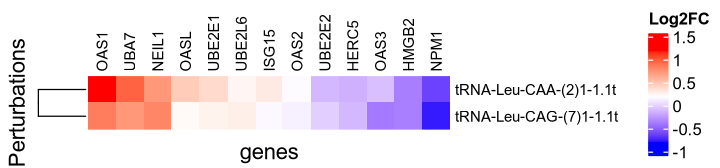

In [114]:
## 'tRNA.Leu.CAA..2.1.1.1t' / 'tRNA.Leu.CAG..7.1.1.1t' (tRF_Leu_CAA.CAG_2 supercluster) ##

filtered_res = lapply(res[7:8], function(x) x %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[13:15])) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)[7:8]
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
#heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('GFI1B', 'CDKN1C', 'FOXO4'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 6
hfix = 1.4

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = mean(heatmap_data)
lower_bound = mean(heatmap_data) - 2*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = mean(heatmap_data) + 2*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

In [3]:
names(hits_pathway_gene_sets)[13:15]

[1] "GO:0032069 REGULATION_OF_NUCLEASE_ACTIVITY"    
[2] "GO:0032020 ISG15-PROTEIN_CONJUGATION"          
[3] "GO:0060700 REGULATION_OF_RIBONUCLEASE_ACTIVITY"

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



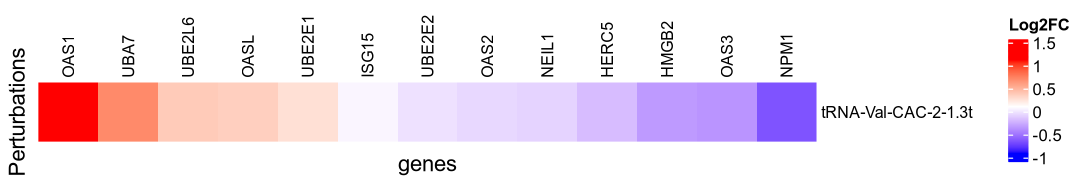

In [119]:
## 'tRNA-Val-CAC-2-1.3t' ##

filtered_res = res[[9]] %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[16:18])) %>% dplyr::select(symbol, log2FoldChange)
rownames(filtered_res) = NULL
filtered_res = filtered_res %>% column_to_rownames(var = 'symbol')
colnames(filtered_res) = names(res)[9]
heatmap_data = filtered_res
#heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('GFI1B', 'CDKN1C', 'FOXO4'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 9
hfix = 1.5

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = mean(heatmap_data)
lower_bound = mean(heatmap_data) - 2*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = mean(heatmap_data) + 2*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

In [5]:
names(hits_pathway_gene_sets)[16:18]

[1] "GO:0032069 REGULATION_OF_NUCLEASE_ACTIVITY"    
[2] "GO:0032020 ISG15-PROTEIN_CONJUGATION"          
[3] "GO:0060700 REGULATION_OF_RIBONUCLEASE_ACTIVITY"

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



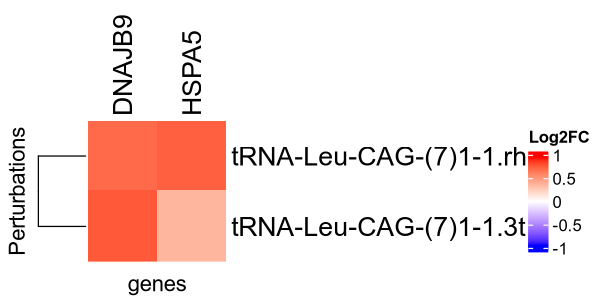

In [261]:
## 'tRNA.Leu.CAG..7.1.1.rh' / 'tRNA.Leu.CAG..7.1.1.3t' (tRF_Leu_CAG_2 supercluster) ##

filtered_res = lapply(res[10:11], function(x) x %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[19:21])) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)[10:11]
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('DNAJB9', 'HSPA5'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 5
hfix = 2.5

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = 0
lower_bound = avg - 5*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = avg + 5*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

## DNAJB9 is upregulated and is a protein folding co-chaperone (https://www.nature.com/articles/s41598-019-46161-4)
## HSPA5 (BiP) is upregulated and is a heat shock protein that is the main endpoint of the unfold protein response (part of downgregulated IRE1 mediated UPR pathway) -- left off here!!


Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"
Warning message in geom_bar(aes(fill = Sample), stat = "summary", fun.y = "mean", :
"Ignoring unknown parameters: `fun.y`"


No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


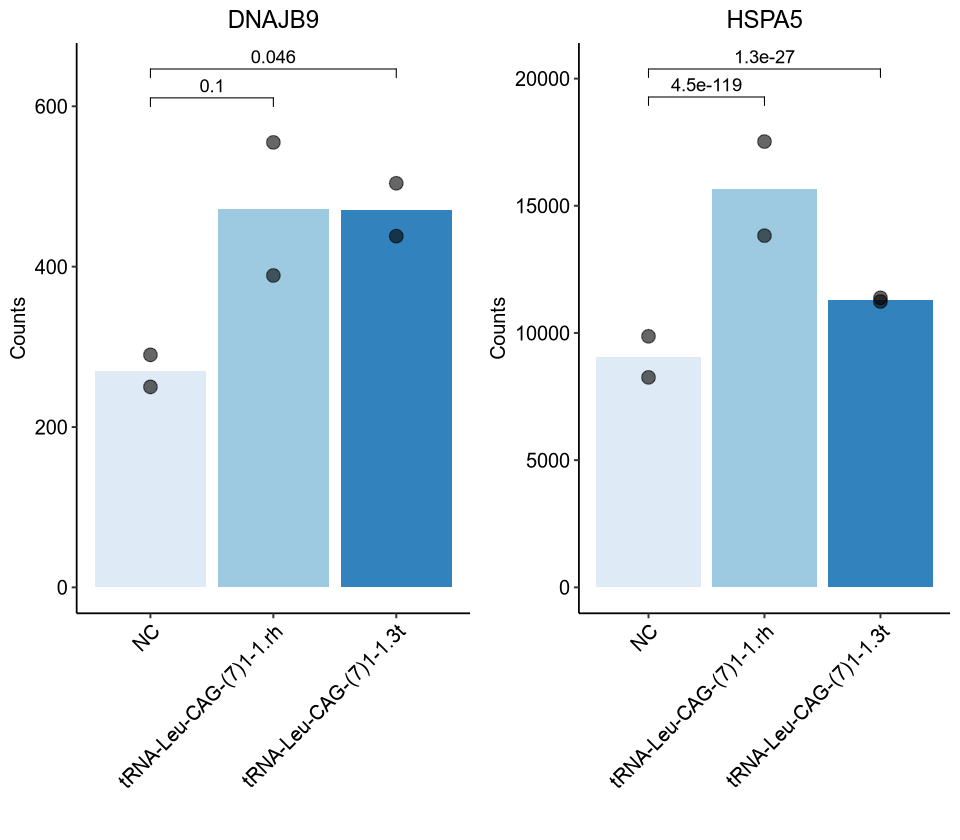

In [24]:
options(repr.plot.width = 8, repr.plot.height = 7)
genes = c('DNAJB9', 'HSPA5')
pvals_df = bind_rows(lapply(res[10:11], function(x) x %>% dplyr::filter(symbol %in% genes) %>% dplyr::select(symbol, log2FoldChange, padj)), .id = 'tRF')
select_genes_counts = exp_data_counts %>% dplyr::filter(SYMBOL %in% genes) %>% dplyr::select(SYMBOL, 'tRNA.Leu.CAG..7.1.1.rh_rep1', 'tRNA.Leu.CAG..7.1.1.rh_rep2', 'tRNA.Leu.CAG..7.1.1.3t_rep1', 'tRNA.Leu.CAG..7.1.1.3t_rep2', NC1_rep1, NC1_rep2) %>% pivot_longer(cols = c('tRNA.Leu.CAG..7.1.1.rh_rep1', 'tRNA.Leu.CAG..7.1.1.rh_rep2', 'tRNA.Leu.CAG..7.1.1.3t_rep1', 'tRNA.Leu.CAG..7.1.1.3t_rep2', 'NC1_rep1', 'NC1_rep2'), names_to = 'Sample', values_to = 'Counts') %>% separate_wider_delim(Sample, "_", names = c('Sample', 'rep'), too_many = "merge") %>% mutate(rep = str_sub(rep, -1)) %>% mutate(Sample = plyr::mapvalues(Sample, from = c('tRNA.Leu.CAG..7.1.1.rh', 'tRNA.Leu.CAG..7.1.1.3t'), to = c('tRNA-Leu-CAG-(7)1-1.rh', 'tRNA-Leu-CAG-(7)1-1.3t')))
# fig_path = '/home/ssobti/projects/mir_tud/'
# saveRDS(pvals_df, paste0(fig_path, 'fig_output/data/fig4/tRF_Leu_CAG_pvals_df.rds'))
# saveRDS(select_genes_counts, paste0(fig_path, 'fig_output/data/fig4/tRF_Leu_CAG_selected_genes_counts.rds'))
select_genes_counts$Sample[select_genes_counts$Sample == 'NC1'] = 'NC'
select_genes_counts$Sample = factor(select_genes_counts$Sample, levels = c('NC', 'tRNA-Leu-CAG-(7)1-1.rh', 'tRNA-Leu-CAG-(7)1-1.3t'))
p.ad_DNAJB9 = pvals_df %>% dplyr::filter(symbol == 'DNAJB9') %>% arrange(factor(symbol, levels = genes)) %>% pull(padj) %>% signif(2)
p.ad_HSPA5 = pvals_df %>% dplyr::filter(symbol == 'HSPA5') %>% arrange(factor(symbol, levels = genes)) %>% pull(padj) %>% signif(2)

y.pos_DNAJB9 = select_genes_counts %>% dplyr::filter(SYMBOL == 'DNAJB9') %>% summarize(max = max(Counts)) %>% pull(max) * 1.1
stat.test_DNAJB9 = data.frame(.y. = 'len', group1 = rep('NC', length(unique(pvals_df$tRF))), group2 = c('tRNA-Leu-CAG-(7)1-1.rh', 'tRNA-Leu-CAG-(7)1-1.3t'), p.adj = p.ad_DNAJB9, y.position = y.pos_DNAJB9)

y.pos_HSPA5 = select_genes_counts %>% dplyr::filter(SYMBOL == 'HSPA5') %>% summarize(max = max(Counts)) %>% pull(max) * 1.1
stat.test_HSPA5 = data.frame(.y. = 'len', group1 = rep('NC', length(unique(pvals_df$tRF))), group2 = c('tRNA-Leu-CAG-(7)1-1.rh', 'tRNA-Leu-CAG-(7)1-1.3t'), p.adj = p.ad_HSPA5, y.position = y.pos_HSPA5)

DNAJB9_barplot = select_genes_counts %>% dplyr::filter(SYMBOL == 'DNAJB9') %>% ggplot(aes(Sample, Counts)) + geom_bar(aes(fill = Sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_pvalue_manual(stat.test_DNAJB9, label = 'p.adj', step.increase = 0.1) + ggtitle(genes[1]) +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('Counts') + scale_fill_brewer(palette = 'Blues', direction = 1) + scale_color_brewer(palette = 'Blues', direction = 1)

HSPA5_barplot = select_genes_counts %>% dplyr::filter(SYMBOL == 'HSPA5') %>% ggplot(aes(Sample, Counts)) + geom_bar(aes(fill = Sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_pvalue_manual(stat.test_HSPA5, label = 'p.adj', step.increase = 0.1) + ggtitle(genes[2]) +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('Counts') + scale_fill_brewer(palette = 'Blues', direction = 1) + scale_color_brewer(palette = 'Blues', direction = 1)

ggarrange(DNAJB9_barplot, HSPA5_barplot, ncol = 2, nrow = 1)

In [9]:
names(hits_pathway_gene_sets)[19:21]

[1] "GO:0031204 POSTTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE,_TRANSLOCATION"
[2] "GO:1903895 NEGATIVE_REGULATION_OF_IRE1-MEDIATED_UNFOLDED_PROTEIN_RESPONSE"
[3] "GO:0030705 CYTOSKELETON-DEPENDENT_INTRACELLULAR_TRANSPORT"

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



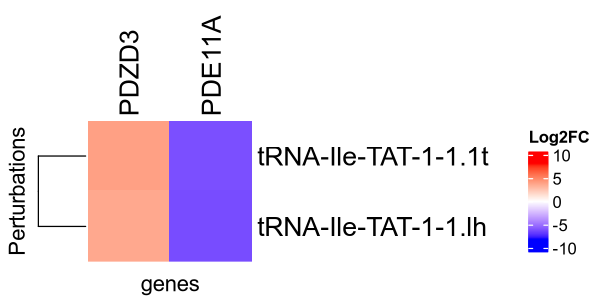

In [285]:
## 'tRNA.Ile.TAT.1.1.lh' / 'tRNA.Ile.TAT.1.1.1t' (tRF_Ile_TAT_2 supercluster) ##

filtered_res = lapply(res[12:13], function(x) x %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets[22:24])) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)[12:13]
filtered_res = lapply(filtered_res, function(x) x %>% drop_na() %>% group_by(symbol) %>% slice_tail() %>% ungroup()) ## or dplyr::distinct(tidyr::drop_na(x), symbol,.keep_all = TRUE)
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('PDE11A', 'PDZD3'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 5
hfix = 2.5

major_text_size = 8
minor_text_size = 16
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = 0
lower_bound = avg - 1.4*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = avg + 1.4*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

## here we see gene expression leading to upregulation of cGMP signalling ##
## PDE11A facilitates breakdown of cGMP leading to cGMP signalling downregulation (https://www.genecards.org/cgi-bin/carddisp.pl?gene=PDE11A)
## PDZD3 is a receptor that causes production of cGMP and therefore upregulates cGMP signalling (https://www.ncbi.nlm.nih.gov/gene/79849)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



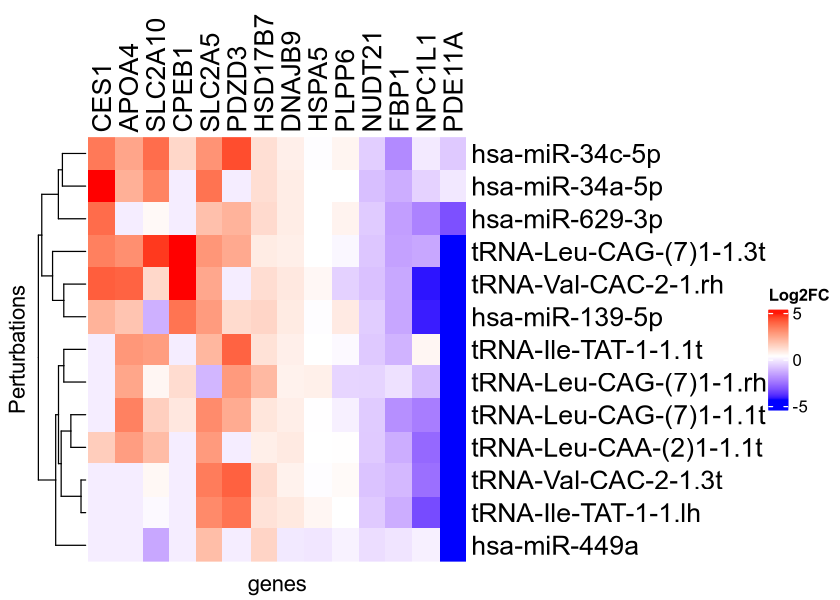

In [16]:
filtered_res = lapply(res, function(x) x %>% dplyr::filter(symbol %in% unlist(hits_pathway_gene_sets)) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)
filtered_res = lapply(filtered_res, function(x) x %>% drop_na() %>% group_by(symbol) %>% slice_tail() %>% ungroup()) ## or dplyr::distinct(tidyr::drop_na(x), symbol,.keep_all = TRUE)
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('SLC2A5', 'SLC2A10', 'FBP1', 'CES1', 'APOA4', 'HSD17B7', 'PLPP6', 'NPC1L1', 'CPEB1', 'NUDT21', 'DNAJB9', 'HSPA5', 'PDE11A', 'PDZD3'),]
heatmap_data = t(heatmap_data)


library(ComplexHeatmap)
wfix = 7
hfix = 5

major_text_size = 8
minor_text_size = 8
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = mean(heatmap_data)
lower_bound = mean(heatmap_data) - 2*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = mean(heatmap_data) + 2*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

In [ ]:
c('SLC2A5', 'SLC2A10', 'FBP1', 'CES1', 'APOA4', 'HSD17B7', 'PLPP6', 'NPC1L1', 'CPEB1', 'NUDT21', 'DNAJB9', 'HSPA5', 'PDE11A', 'PDZD3')

In [17]:
res[[5]] %>% arrange(desc(log2FoldChange)) %>% head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000226777.7,12.33000,9.202327,3.6222057,2.540531,1.106842e-02,6.047428e-02,FAM30A
ENSG00000117983.17,2799.76962,8.771697,0.4659672,18.824711,4.737873e-79,2.198486e-76,MUC5B
ENSG00000241790.2,40.68124,8.293493,1.7849771,4.646274,3.379840e-06,6.291280e-05,ENO1P4
ENSG00000137809.17,11.45994,8.176581,2.4287377,3.366597,7.610179e-04,7.154596e-03,ITGA11
ENSG00000176020.9,34.79134,8.055493,2.4980470,3.224716,1.260976e-03,1.090775e-02,AMIGO3
ENSG00000163993.7,26.05144,7.848790,1.4984210,5.238041,1.622903e-07,4.044597e-06,S100P


In [18]:
names(res)

[1] "hsa-miR-34a-5p"         "hsa-miR-34c-5p"         "hsa-miR-449a"          
 [4] "hsa-miR-629-3p"         "hsa-miR-139-5p"         "tRNA-Val-CAC-2-1.rh"   
 [7] "tRNA-Leu-CAA-(2)1-1.1t" "tRNA-Leu-CAG-(7)1-1.1t" "tRNA-Val-CAC-2-1.3t"   
[10] "tRNA-Leu-CAG-(7)1-1.rh" "tRNA-Leu-CAG-(7)1-1.3t" "tRNA-Ile-TAT-1-1.lh"   
[13] "tRNA-Ile-TAT-1-1.1t"

### GSEA ###

#### 'miR-34-5p/449-5p' ####

In [21]:
## 'miR-34-5p/449-5p' ## 
## only hsa-miR-34a-5p','hsa-miR-34c-5p' seem to affect glycolysis based on results below, hsa-miR-449a has no significant effect

tuds_of_interest = c('hsa-miR-34a-5p','hsa-miR-34c-5p','hsa-miR-449a')
tuds_of_interest_indexes = which(names(res) %in% tuds_of_interest)
gse = list()
n = 1
for (i in tuds_of_interest_indexes){
    gene_list = res[[i]]$stat[order(-res[[i]]$stat)]
    names(gene_list) = str_split_i(rownames(res[[i]])[order(-res[[i]]$stat)], '\\.', 1)
    gene_list = gene_list[!is.na(gene_list)]
    gse[[n]] = clusterProfiler::gseGO(gene_list, ont = 'BP', keyType = 'ENSEMBL', OrgDb = 'org.Hs.eg.db', eps = 1e-300, seed = 1)
    n = n + 1
}

#saveRDS(gse, '/home/ssobti/projects/mir_tud/output_data/wetlab_followup/bulk_rna_seq/pathway_validation/gse_list_miR-34-5p_449-5p.rds')

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.47% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (1.98% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.39% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...



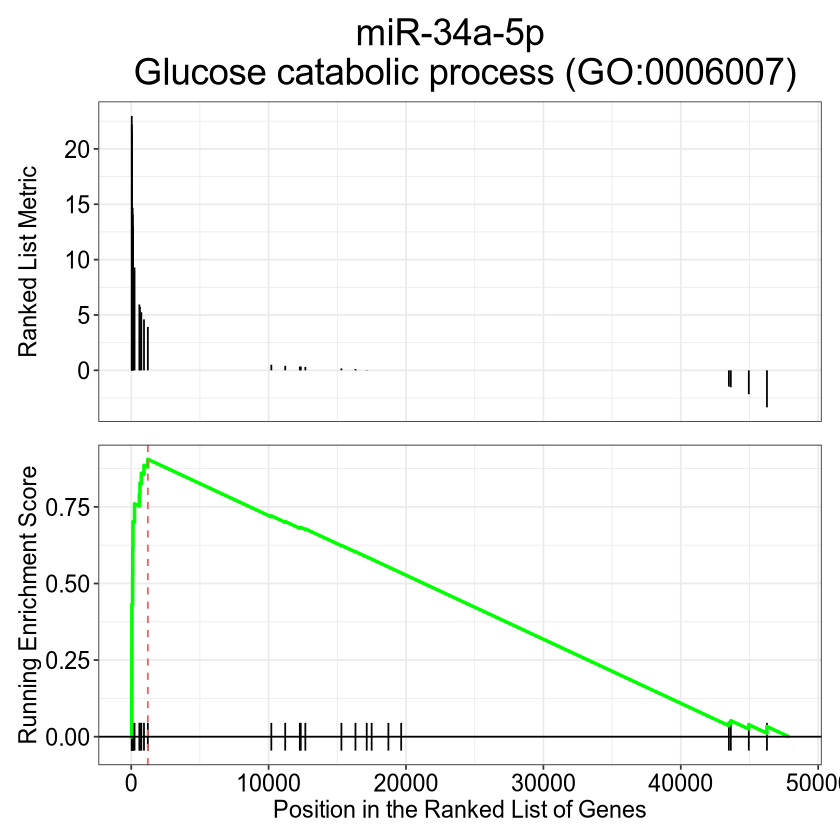

In [124]:
gseaplot(gse[[1]], geneSetID = 'GO:0006007', title = 'miR-34a-5p  \n Glucose catabolic process (GO:0006007)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.0004190069

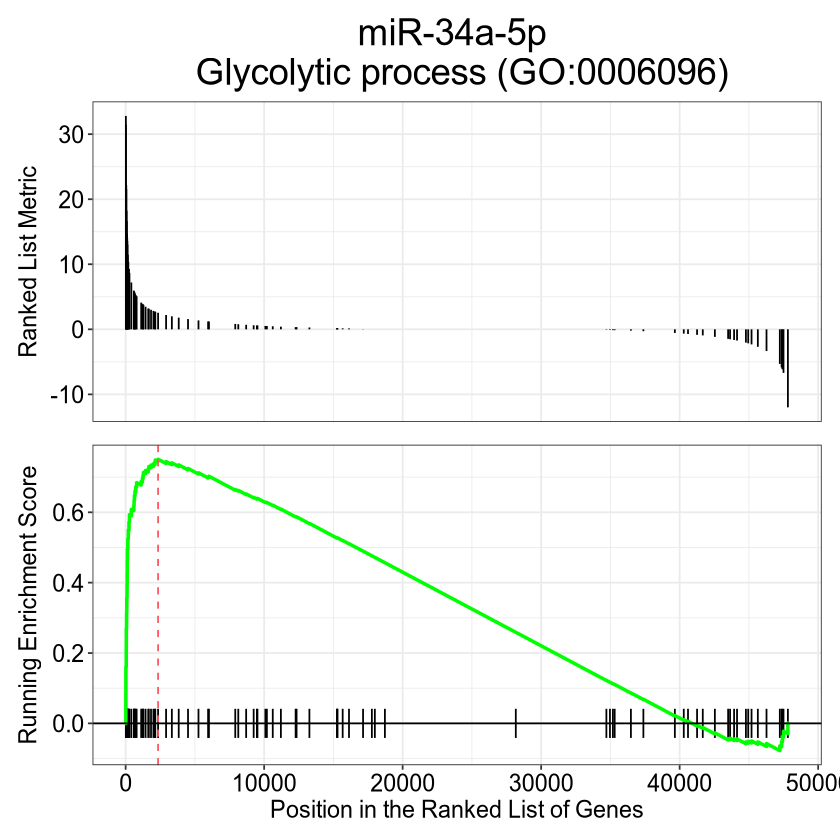

In [121]:
gseaplot(gse[[1]], geneSetID = 'GO:0006096', title = 'miR-34a-5p \n Glycolytic process (GO:0006096)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.0005739487

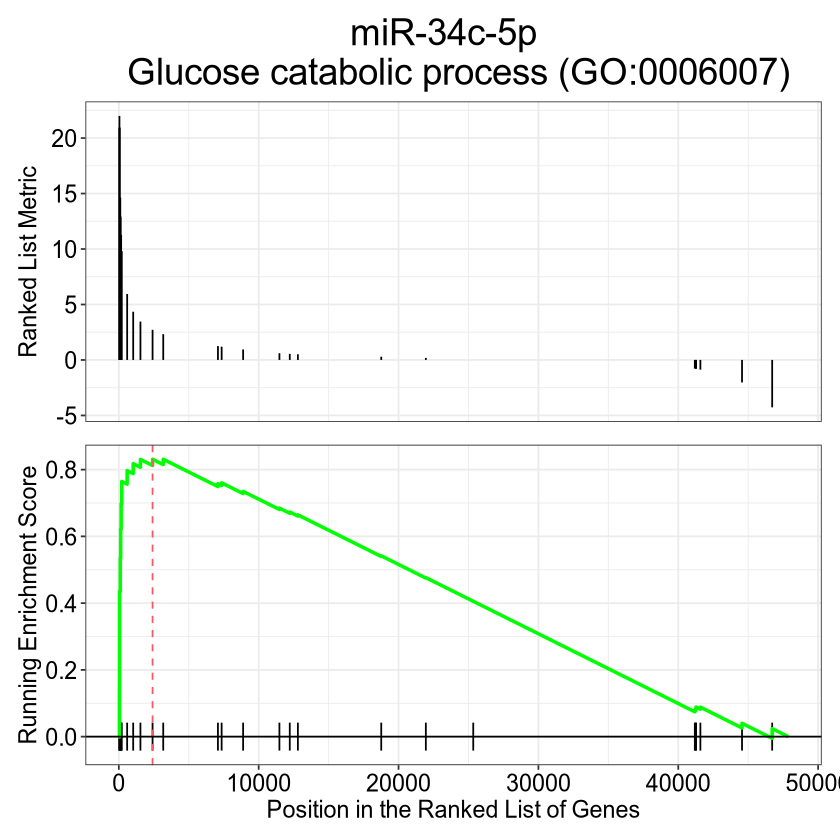

In [28]:
gseaplot(gse[[2]], geneSetID = 'GO:0006007', title = 'miR-34c-5p  \n Glucose catabolic process (GO:0006007)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.002846306

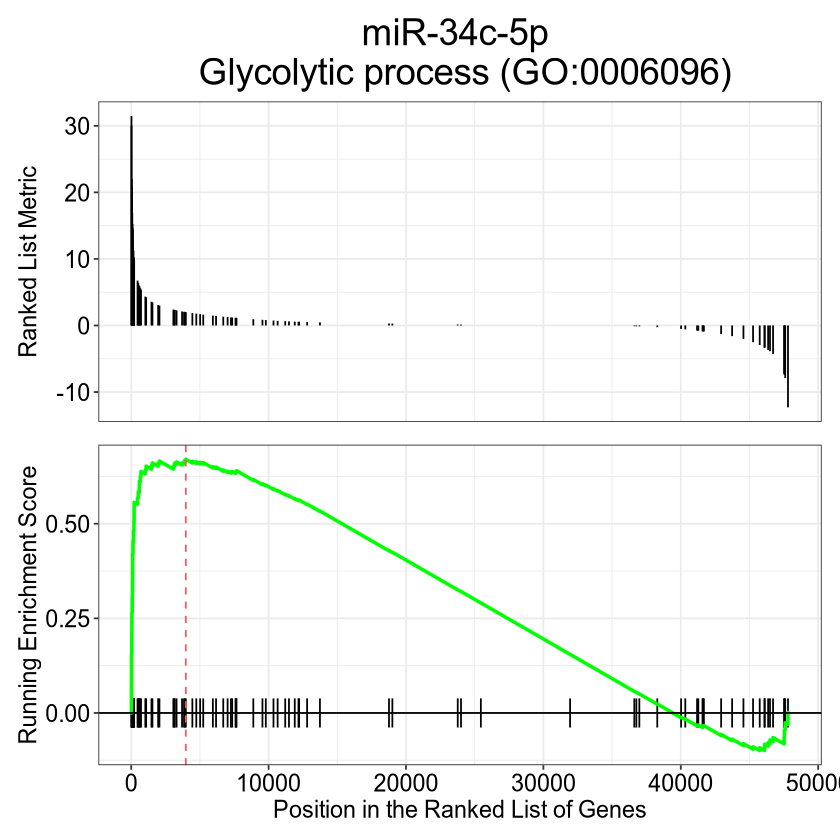

In [29]:
gseaplot(gse[[2]], geneSetID = 'GO:0006096', title = 'miR-34c-5p \n Glycolytic process (GO:0006096)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.002314464

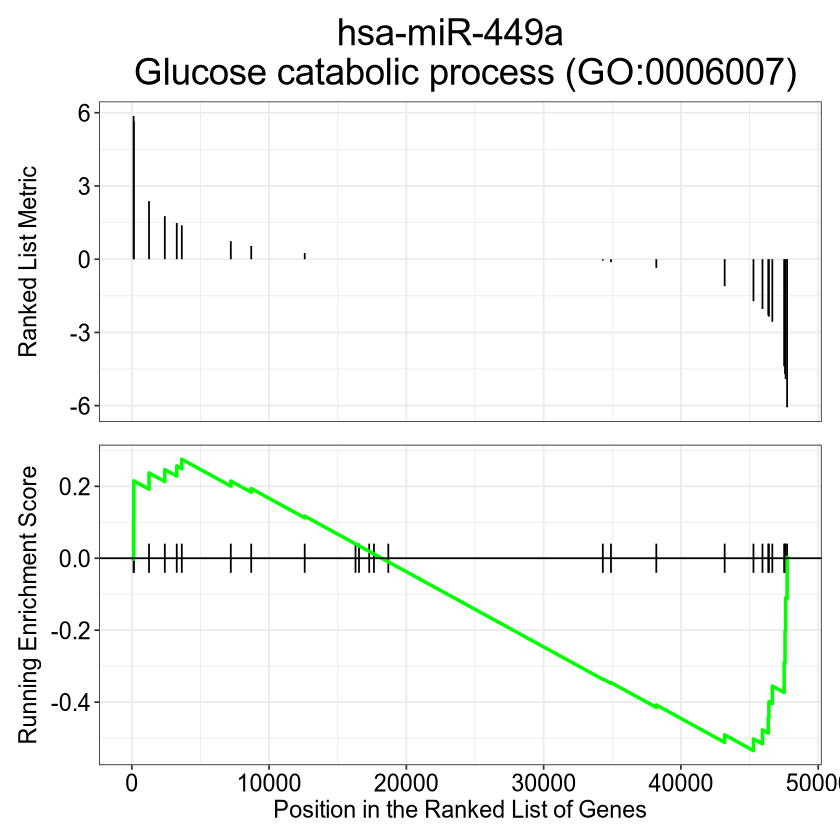

In [66]:
gseaplot(gse[[3]], geneSetID = 'GO:0006007', title = 'hsa-miR-449a  \n Glucose catabolic process (GO:0006007)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = not significant

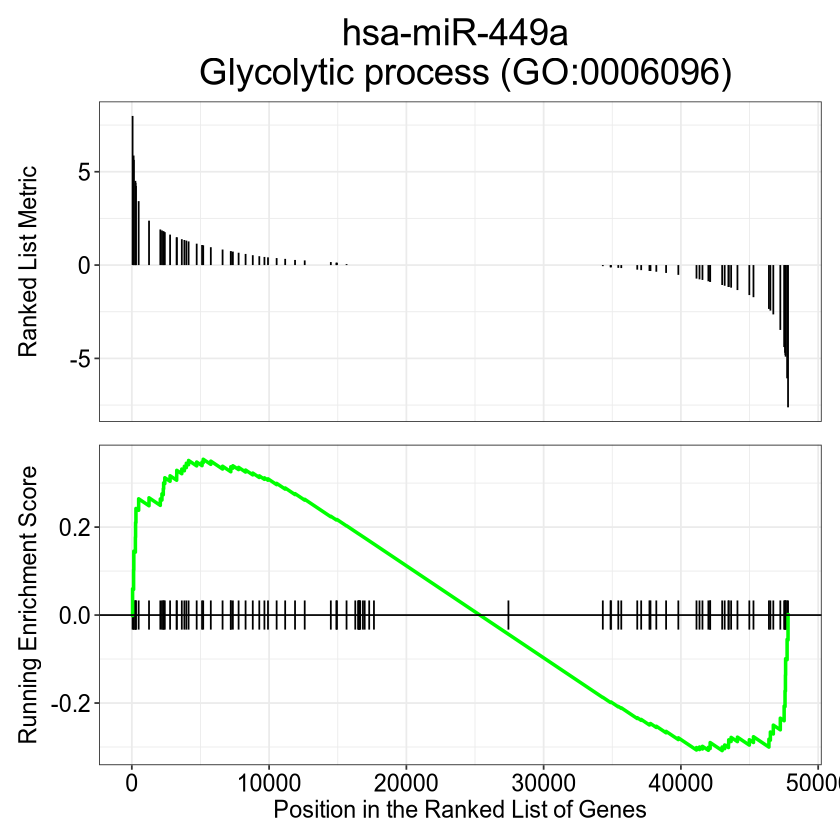

In [67]:
gseaplot(gse[[3]], geneSetID = 'GO:0006096', title = 'hsa-miR-449a \n Glycolytic process (GO:0006096)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = not significant

#### 'miR-139-5p' ####

In [ ]:
## CES1 over-expression in macrophages leads to an increase in cholesteryl esterification and free cholesterol efflux, can indicate excess cholesterol in cells (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5736751/#:~:text=Human%20carboxylesterase%201%20(CES1)%20is,Ldlr%20%E2%88%92%2F%E2%88%92%20mice4.)
## APOA4 is upregulated which promotes cholesterol efflux and esterification leading to HDL formation to deposit cholesterol to liver, can indicate excess free cholesterol in cells, ie cholestorl and sterol synthesis may be in overdrive (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10243815/)
## HSD17B7 participates in postsqualene cholesterol biosynthesis (https://pubmed.ncbi.nlm.nih.gov/12829805/)
## PLPP6 (PDP1) regulates the biosynthesis of cholesterol and related sterols by dephosphorylating presqualene and farnesyl diphosphate, two key intermediates in this biosynthetic pathway (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2859554/)
## NPC1L1 imports cholesterol into cells and is downregulated here, indicating excess cholesterol within cells causing stoppage of cholesterol import (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3965667/)
## since HMGCR, NR5A2, VPS54 control cholesterol synthesis, homeostasis, and transport genes are normal targets of this miRNA, inhibiting this miRNA is leading to excess cholesterol/sterol synthesis in cells

In [75]:
## 'miR-139-5p' ## 

tuds_of_interest = 'hsa-miR-139-5p'
tuds_of_interest_indexes = which(names(res) %in% tuds_of_interest)

gene_list = res[[tuds_of_interest_indexes]]$stat[order(-res[[tuds_of_interest_indexes]]$stat)]
names(gene_list) = str_split_i(rownames(res[[tuds_of_interest_indexes]])[order(-res[[tuds_of_interest_indexes]]$stat)], '\\.', 1)
gene_list = gene_list[!is.na(gene_list)]
gse = clusterProfiler::gseGO(gene_list, ont = 'BP', keyType = 'ENSEMBL', OrgDb = 'org.Hs.eg.db', eps = 1e-300, seed = 1)
#saveRDS(gse, '/home/ssobti/projects/mir_tud/output_data/wetlab_followup/bulk_rna_seq/pathway_validation/gse_list_miR-139-5p.rds')

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.52% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...



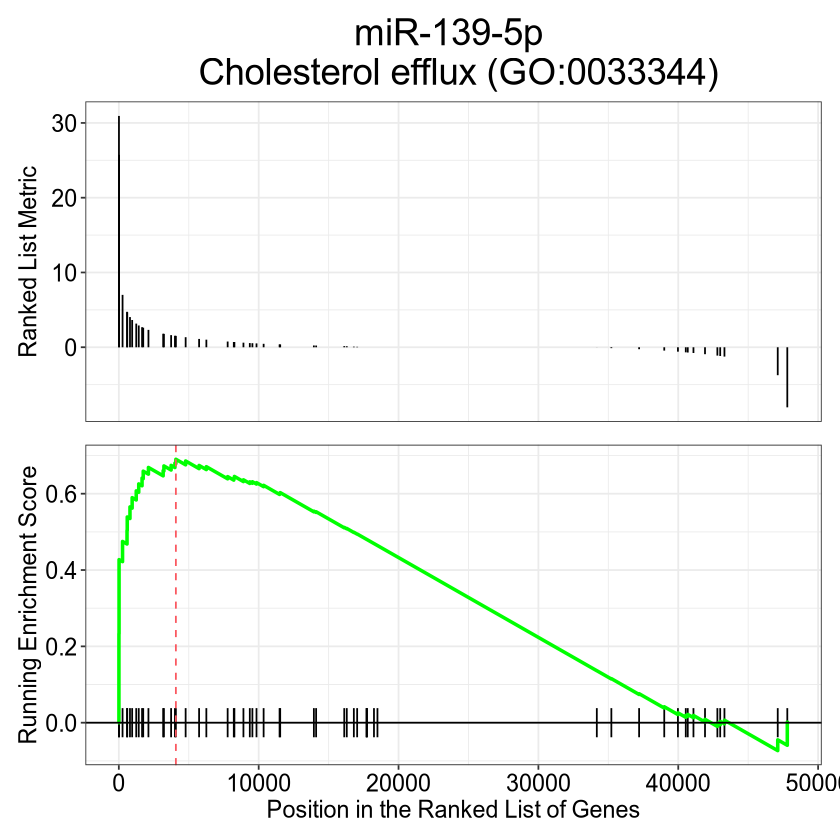

In [ ]:
gseaplot(gse, geneSetID = 'GO:0033344', title = 'miR-139-5p \n Cholesterol efflux (GO:0033344)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.025422091

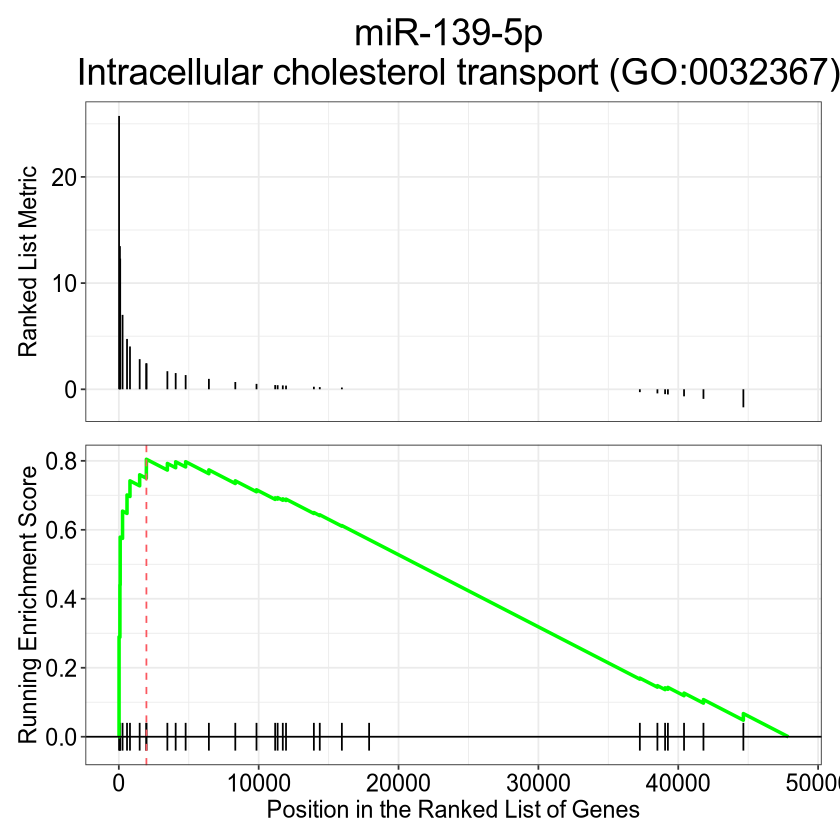

In [95]:
gseaplot(gse, geneSetID = 'GO:0032367', title = 'miR-139-5p \n Intracellular cholesterol transport (GO:0032367)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.018037268

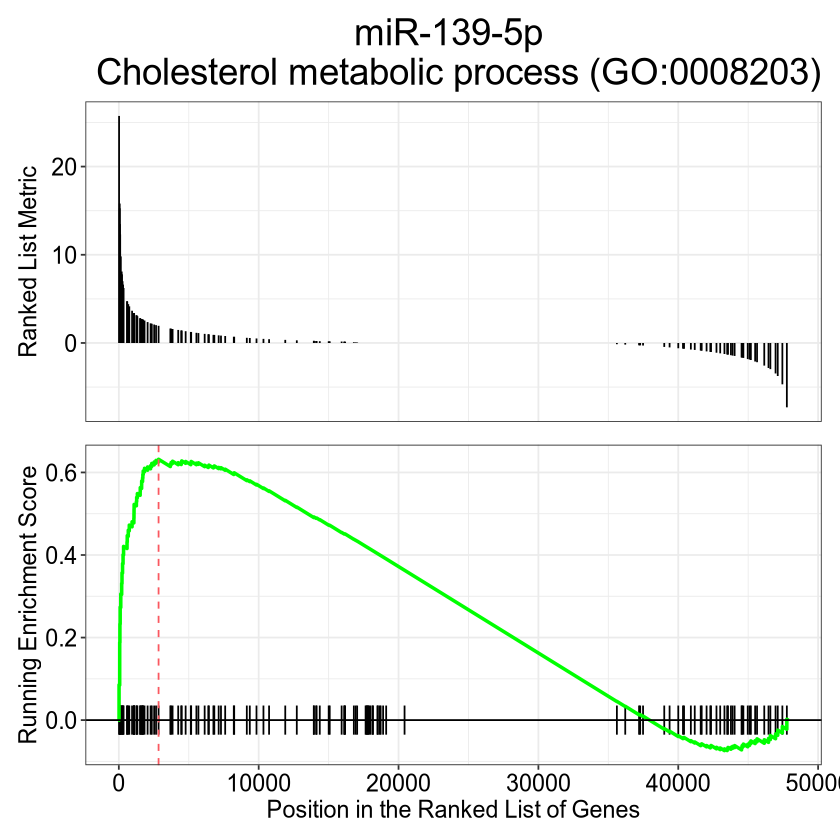

In [ ]:
gseaplot(gse, geneSetID = 'GO:0008203', title = 'miR-139-5p \n Cholesterol metabolic process (GO:0008203)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.005878276

#### tRF_Leu_CAG_2 supercluster ####

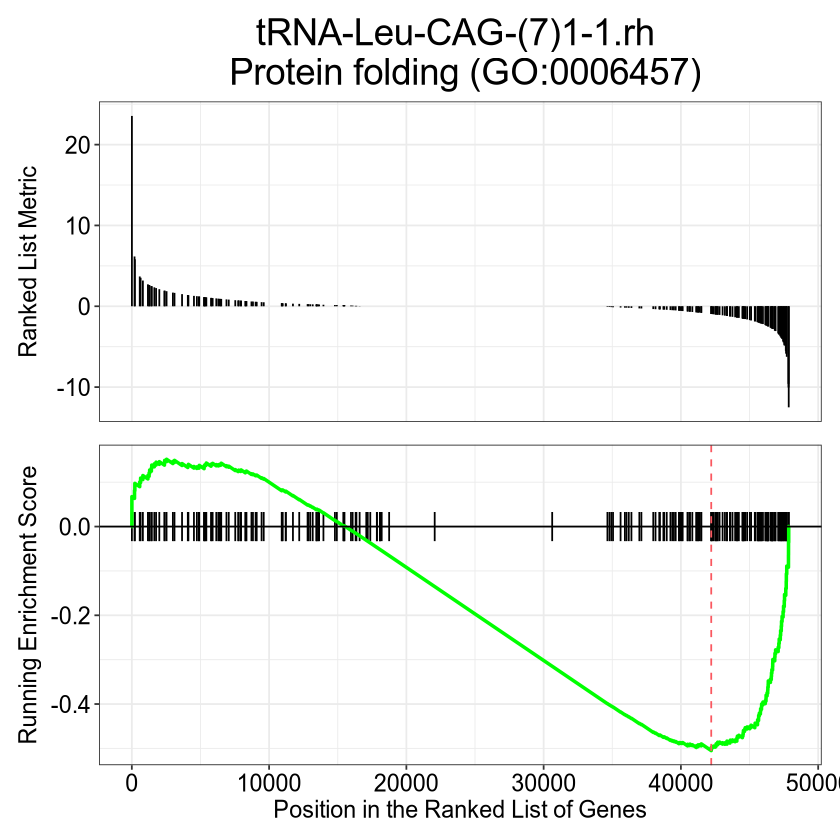

In [120]:
gseaplot(gse[[1]], geneSetID = 'GO:0006457', title = 'tRNA-Leu-CAG-(7)1-1.rh \n Protein folding (GO:0006457)', pvalueCutoff = 0.05, color = 'black')
## de-enriched
## p.adjust = 0.02331297

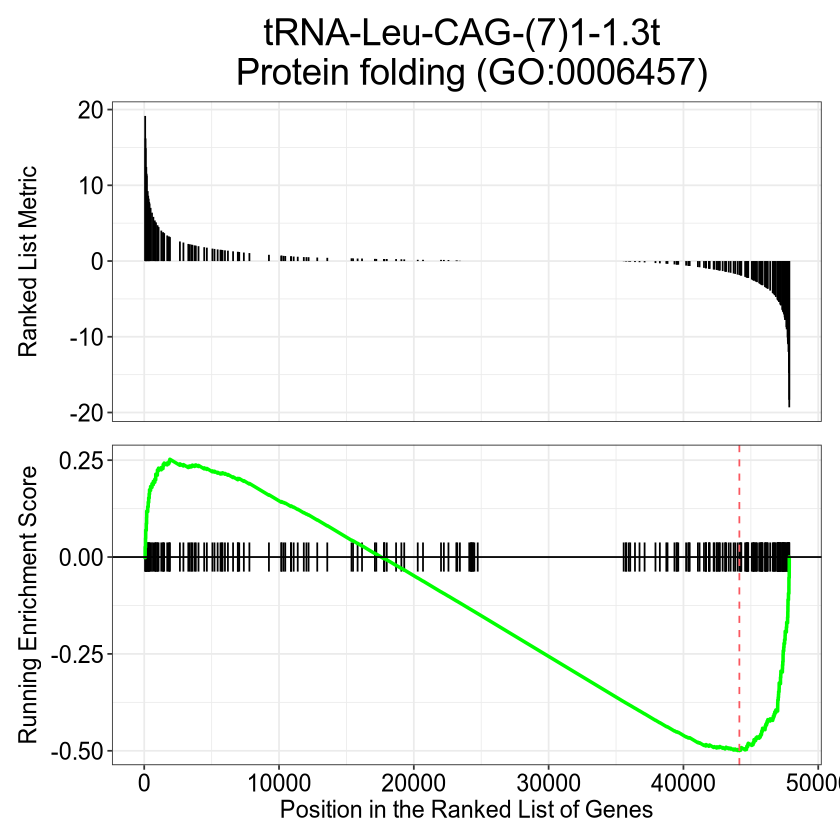

In [121]:
gseaplot(gse[[2]], geneSetID = 'GO:0006457', title = 'tRNA-Leu-CAG-(7)1-1.3t \n Protein folding (GO:0006457)', pvalueCutoff = 0.05, color = 'black')
## de-enriched
## p.adjust = 0.004993511

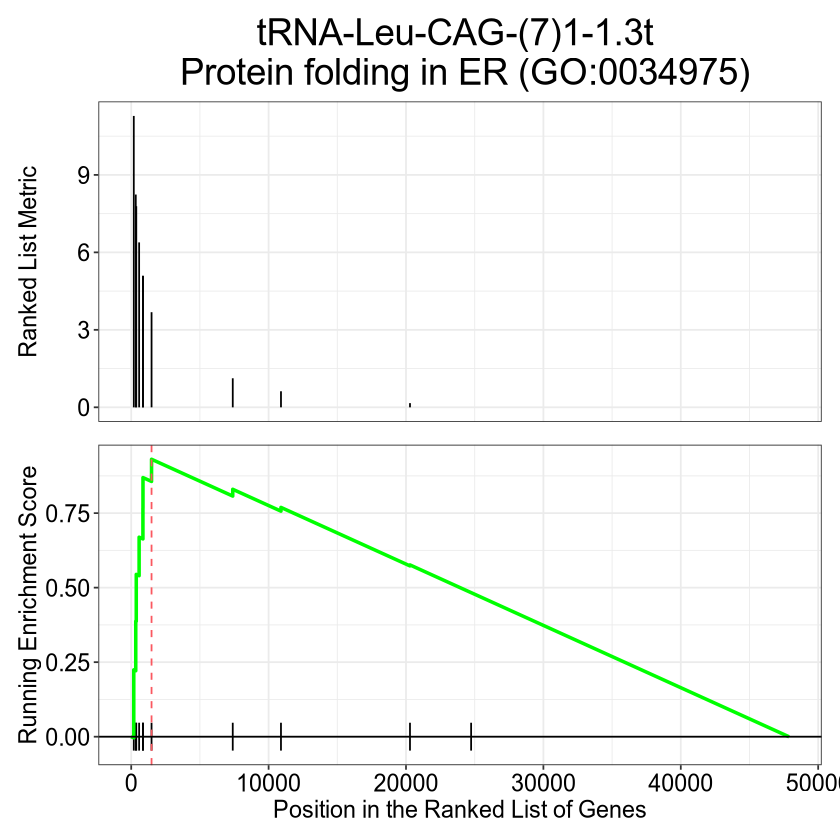

In [123]:
gseaplot(gse[[2]], geneSetID = 'GO:0034975', title = 'tRNA-Leu-CAG-(7)1-1.3t \n Protein folding in ER (GO:0034975)', pvalueCutoff = 0.05, color = 'black')
## p.adjust = 0.011117331

#### tRNA-Val-CAC-2-1.rh ####

In [125]:
## 'tRNA-Val-CAC-2-1.rh' ## 

tuds_of_interest = 'tRNA-Val-CAC-2-1.rh'
tuds_of_interest_indexes = which(names(res) %in% tuds_of_interest)

gene_list = res[[tuds_of_interest_indexes]]$stat[order(-res[[tuds_of_interest_indexes]]$stat)]
names(gene_list) = str_split_i(rownames(res[[tuds_of_interest_indexes]])[order(-res[[tuds_of_interest_indexes]]$stat)], '\\.', 1)
gene_list = gene_list[!is.na(gene_list)]
gse = clusterProfiler::gseGO(gene_list, ont = 'BP', keyType = 'ENSEMBL', OrgDb = 'org.Hs.eg.db', eps = 1e-300, seed = 1)
#saveRDS(gse, '/home/ssobti/projects/mir_tud/output_data/wetlab_followup/bulk_rna_seq/pathway_validation/gse_list_tRNA-Val-CAC-2-1_rh.rds')

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.73% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...



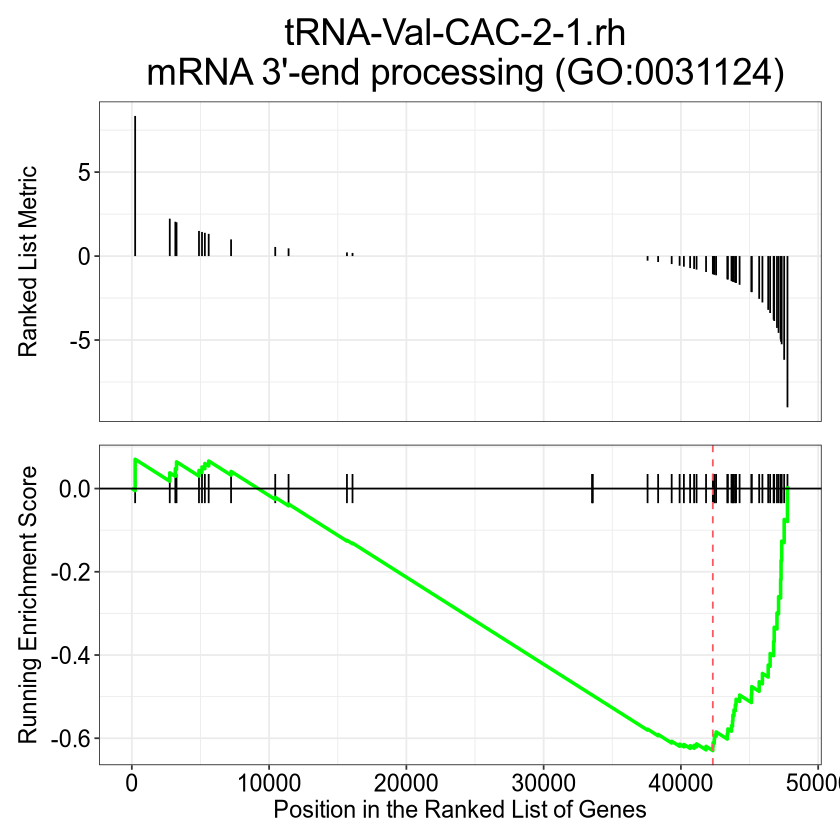

In [131]:
gseaplot(gse, geneSetID = 'GO:0031124', title = 'tRNA-Val-CAC-2-1.rh \n mRNA 3\'-end processing (GO:0031124)', pvalueCutoff = 0.05, color = 'black')
## de-enriched
## p.adjust = 0.04161715

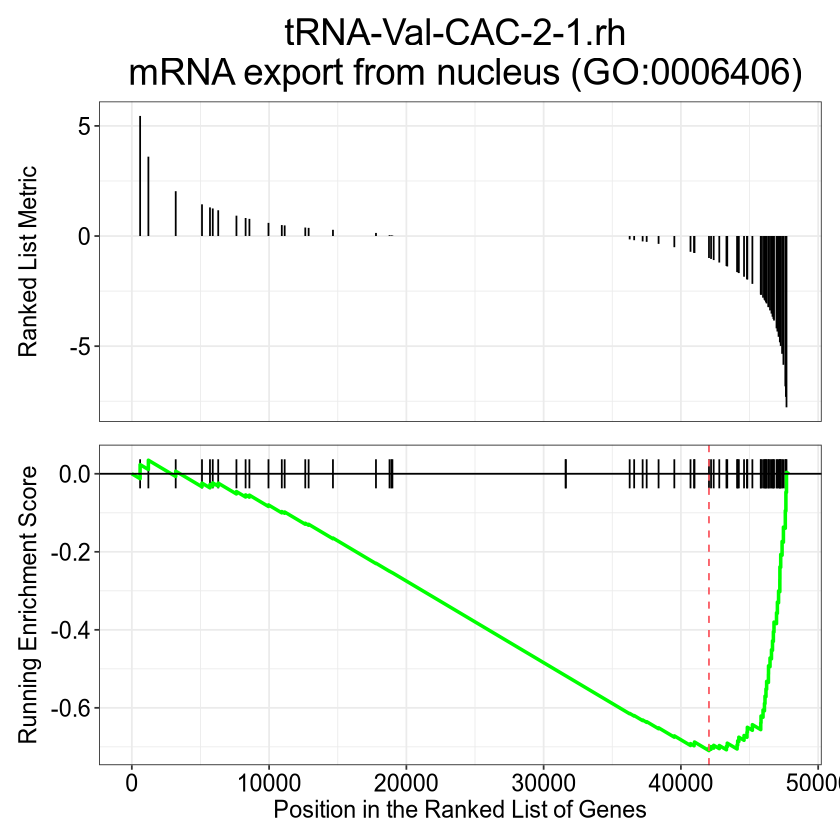

In [142]:
gseaplot(gse, geneSetID = 'GO:0006406', title = 'tRNA-Val-CAC-2-1.rh \n mRNA export from nucleus (GO:0006406)', pvalueCutoff = 0.05, color = 'black')
## de-enriched
## p.adjust = 0.001556308

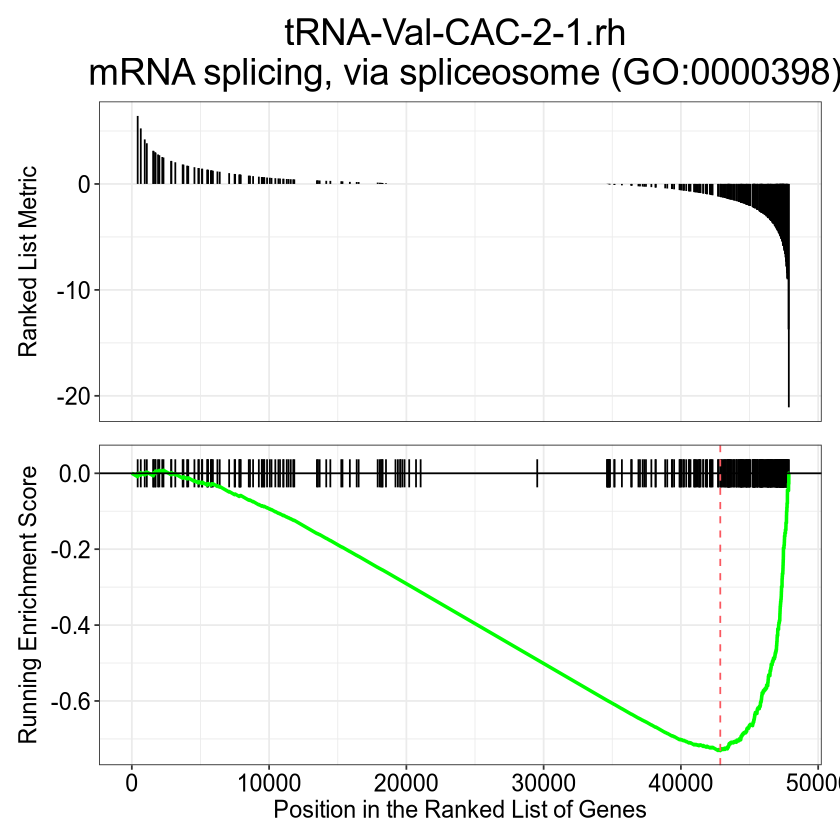

In [143]:
gseaplot(gse, geneSetID = 'GO:0000398', title = 'tRNA-Val-CAC-2-1.rh \n mRNA splicing, via spliceosome (GO:0000398)', pvalueCutoff = 0.05, color = 'black')
## de-enriched
## p.adjust = 5.871925e-21